In [8]:
# Import libraries
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pandas as pd, pickle
import random
from random import seed, random, randint, sample

import tensorflow.keras as keras
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, GlobalMaxPool1D, Activation, MaxPool1D, Conv1D, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import librosa 
import librosa.display
from sklearn.metrics import confusion_matrix, classification_report
from skimage.transform import resize
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler
from librosa.filters import mel
import pywt
import scipy
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import subprocess, os
import shutil

from pathlib import Path

These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130.
  127.45098039  125.          122.641509

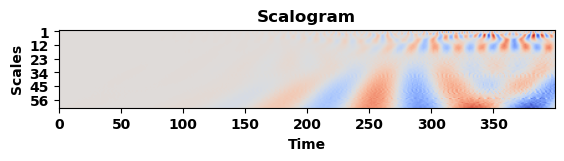

In [24]:
# Read a sample file
filename = os.path.dirname(os.getcwd()) +  "/data/raw/cv_delta/clips/common_voice_en_34925857.mp3"

# Read an audio file using librosa
y, sr = librosa.load(filename)

wavelet = 'morl' # wavelet type: morlet
sr = 8000 # sampling frequency: 8KHz
widths = np.arange(1, 64) # scales for morlet wavelet 
print("These are the scales that we are using: ", widths)
dt = 1/sr # timestep difference

frequencies = pywt.scale2frequency(wavelet, widths) / dt # Get frequencies corresponding to scales
print("These are the frequencies that re associated with the scales: ", frequencies)

# Compute continuous wavelet transform of the audio numpy array
wavelet_coeffs, freqs = pywt.cwt(y, widths, wavelet = wavelet, sampling_period=dt)
print("Shape of wavelet transform: ", wavelet_coeffs.shape)

# Display the scalogram. We will display a small part of scalogram because the length of scalogram is too big.
plt.imshow(wavelet_coeffs[:,:400], cmap='coolwarm')
plt.xlabel("Time")
plt.ylabel("Scales")
plt.yticks(widths[0::11])
plt.title("Scalogram")
plt.show()

import numpy as np
import matplotlib.pyplot as plt



C:\Users\noahc\AppData\Local\Temp\ipykernel_22784\22909426.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  size = (10*py/np.float(dpi), 10*px/np.float(dpi)) # note the np.float()


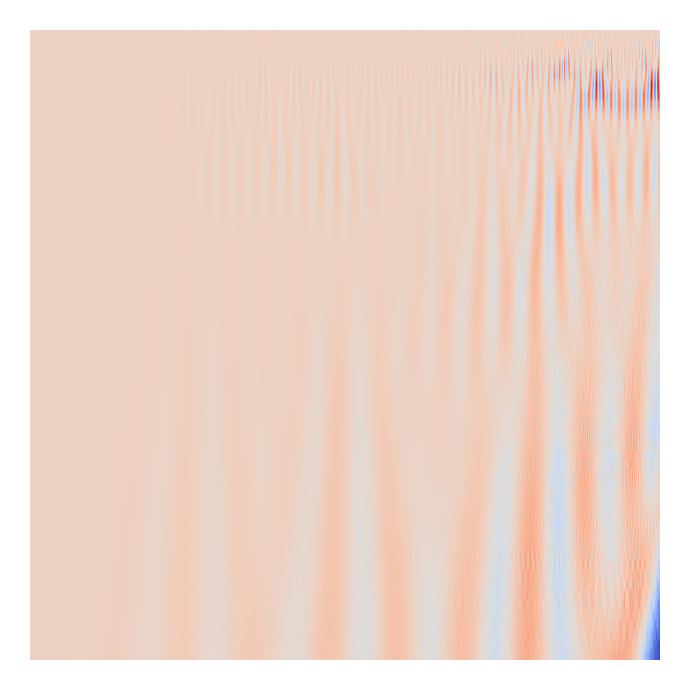

In [45]:
dest= os.path.dirname(os.getcwd()) + "/data/raw/cv_delta/scales/"
def plot_im(image, dpi=300):
    px,py = image.shape # depending of your matplotlib.rc you may 
         #have to use py,px instead
    #px,py = im[:,:,0].shape # if image has a (x,y,z) shape 
    size = (10*py/np.float(dpi), 10*px/np.float(dpi)) # note the np.float()

    fig = plt.figure(figsize=size, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])
    # Customize the axis
    # remove top and right spines
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    # turn off ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.imshow(image, cmap='coolwarm')
    ax.set_aspect('auto')
    ax.set_box_aspect(1)
    plt.savefig(os.path.join(dest, 'new_plt.png'), bbox_inches = 'tight')
    plt.show()
     
    plt.close()
    
plot_im(wavelet_coeffs[:,80:800])

In [10]:
# The data in the current directory inside the doler "recordings".
input_path = os.path.dirname(os.getcwd()) + "/data/raw/cv_delta"
dest= os.path.dirname(os.getcwd()) + "/data/raw/cv_delta/scales/human"
# Read audio files from the directory. For this tutorial, we will only classify 3 speakers: george, jackson, and lucas.
# Audio files have this format : {digit}_{speaker}_{speaker_filenumber}.wav



In [12]:
os.getcwd()


'C:\\Users\\noahc\\VC_Repo\\notebooks'

In [21]:
audio = [] # List to store audio np arrays
y = [] # List to store the target class labels


for subdir in os.listdir(input_path):
        # Get the full path of the subdirectory
        subdir_path = os.path.join(input_path, subdir)
        # Check if it is a directory and has DR in its name
        if os.path.isdir(subdir_path) and "AI" in subdir:
            # Loop through the files in the subsubdirectory
            for file in os.listdir(subdir_path):
                # Get the full path of the file
                file_path = os.path.join(subdir_path, file)
                # Check if it is a file and has .mp3 extension
                if os.path.isfile(file_path) and file.endswith(".mp3"):
                    # Append it to the audio files list
                    audio.append(file_path)
                    y.append(1)
        elif os.path.isdir(subdir_path) and "clip" in subdir:
            # Loop through the files in the subsubdirectory
            for file in os.listdir(subdir_path):
                # Get the full path of the file
                file_path = os.path.join(subdir_path, file)
                # Check if it is a file and has .mp3 extension
                if os.path.isfile(file_path) and file.endswith(".mp3"):
                    # Append it to the wav files list
                    audio.append(file_path)
                    y.append(0)
                    
                

# Write the audio data in a npz file so that we don't have to read the audio files again. We can load the data from npz file. Also, the npz format is very space efficient.
audio_train, audio_test, y_train, y_test = train_test_split(audio, y, test_size=0.3)
np.savez_compressed(os.getcwd()+"/training_raw_audio", a=audio_train, b=y_train)
np.savez_compressed(os.getcwd()+"/testing_raw_audio", a=audio_test, b=y_test)

print("Finished writing to npz file...")

# Print the class distribution
print("Training Data class distribution: ", np.unique(y_train, return_counts=True))
print("Testing Data class distribution: ", np.unique(y_test, return_counts=True))

Finished writing to npz file...
Training Data class distribution:  (array([0, 1]), array([28517,  1193], dtype=int64))
Testing Data class distribution:  (array([0, 1]), array([12188,   545], dtype=int64))


In [22]:
def compute_wavelet_features(X) :

    # Define a few parameters
    wavelet = 'morl' # wavelet type: morlet
    sr = 8000 # sampling frequency: 8KHz
    widths = np.arange(1, 256) # scales for morlet wavelet 
    dt = 1/sr # timestep difference

    frequencies = pywt.scale2frequency(wavelet, widths) / dt # Get frequencies corresponding to scales
    
    # Create a filter to select frequencies between 80Hz and 5KHz
    upper = ([x for x in range(len(widths)) if frequencies[x] > 1000])[-1]
    lower = ([x for x in range(len(widths)) if frequencies[x] < 80])[0]
    widths = widths[upper:lower] # Select scales in this frequency range

    # Compute continuous wavelet transform of the audio numpy array
    wavelet_coeffs, freqs = pywt.cwt(X, widths, wavelet = wavelet, sampling_period=dt)
    # print(wavelet_coeffs.shape)
    # sys.exit(1)

    # Split the coefficients into frames of length 800
    start = 0
    end = wavelet_coeffs.shape[1]
    frames = []
    frame_size = 400
    count = 0

    while start+frame_size <= end-1 :

        f = wavelet_coeffs[:,start:start+frame_size]        

        # Total samples in a frame will not be a multiple of 800 everytime. If the last frame length is less than 800, we can skip it.
        assert f.shape[1] == frame_size # assert frame lengths are equal to the frame_size parameter

        frames.append(f)
        start += frame_size


    # Convert frames to numpy array
    frames = np.array(frames)
    frames = frames.reshape((len(frames), wavelet_coeffs.shape[0], frame_size))

    return frames

In [23]:
### Compute Training data features. We have each sample into frames of length 400

indices = []
WaveletFeatTrain = [] # Store wavelet features
WaveletYTrain = [] # Store class labels corresponding to wavelet features from an audio sample
uniq_id = []
count = 0

for i in range(2) :
    
    ind, = np.where(y_train == i)
    seed(i)
    ind = ind.tolist()
    ind = sample(ind, 100)
    audio_samples = audio_train[ind]
    num_rand_samp = 100

    for j in tqdm(range(len(audio_samples))) :

        # print("i ", i, " j ", j, "/", len(audio_samples))
        curr_sample = audio_samples[j]
        seq, _ = librosa.load(curr_sample) 
        F = compute_wavelet_features(seq)
        F = F.astype(np.float16)

        # Generate target labels corresponding to the frames of each sample
        indices = np.arange(0, len(F), 1)
        indices = indices.tolist()
        indices = sample(indices, min(num_rand_samp, len(indices)))
        F = F[indices]
        uniq_id += [count] * len(F)
        WaveletYTrain += [i] * len(F)

        if count == 0 :
            WaveletFeatTrain = F
        else :
            WaveletFeatTrain = np.concatenate((WaveletFeatTrain, F), axis=0) 
        
        count += 1


    
print("X: ", WaveletFeatTrain.shape)

WaveletYTrain = np.array(WaveletYTrain) # Convert to numpy array
uniq_id = np.array(uniq_id)
print("Y: ", WaveletYTrain.shape, " unique: ", np.unique(WaveletYTrain, return_counts=True))
# Write all features to a .npz file
np.savez_compressed(os.getcwd()+"/training_features", a=WaveletFeatTrain, b=WaveletYTrain, c=uniq_id)

ValueError: Sample larger than population or is negative